In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import dask

import shapely
import geopandas as gpd
import salem

import cartopy as cart
import cartopy.crs as ccrs

import ecco_v4_py as ecco

import cmocean.cm as cmo
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as ticker
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
def get_gdf_patch(coords_patch):
    # Replace each pair of points by 10 points for projected map
    geometry = []
    segments = zip(coords_patch[:-2:2], coords_patch[1:-1:2], coords_patch[2::2], 
                   coords_patch[3::2])
    
    for line in [shapely.geometry.LineString([(x1, y1), (x2, y2)]) for (x1,y1,x2,y2) in segments]:
        for length in np.linspace(0,1,11):
            geometry.append( line.interpolate(length, normalized=True) )
        
    gdf_patch = gpd.GeoDataFrame([], geometry=geometry)
    
    # Convert Points to Polygo
    gdf_patch['geometry'] = gdf_patch['geometry'].apply(lambda x: x.coords[0])
    
    gdf_patch['shape_id'] = 0
    gdf_patch = gdf_patch.groupby('shape_id')['geometry'].apply(lambda x: shapely.geometry.Polygon(x.tolist())).reset_index()
    gdf_patch = gpd.GeoDataFrame(gdf_patch, geometry = 'geometry')
    
    # Salem uses this attribute:
    gdf_patch.crs = {'init': 'epsg:4326'}
    
    return gdf_patch

In [3]:
main = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r4_output/').rename({'face': 'tile'})
budg = xr.open_zarr('/mnt/efs/data/ecco/zarr/eccov4r4_budgets/').rename({'face': 'tile'})

In [4]:
# Volume (m^3)
vol = (main.rA*main.drF*main.hFacC).transpose('k','tile','j','i')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  


In [5]:
# Volume fluxes (m^3/s)
budg_vol = budg*vol

/usr/local/lib/python3.6/dist-packages/dask/array/core.py:3918: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs,
/usr/local/lib/python3.6/dist-packages/dask/array/core.py:3918: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs,
/usr/local/lib/python3.6/dist-packages/dask/array/core.py:3918: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs,
/usr/local/lib/python3.6/dist-packages/dask/array/core.py:3918: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs,
/usr/local/lib/python3.6/dist-packages/dask/array/core.py:3918: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs,
/usr/local/lib/python3.6/dist-packages/dask/array/core.py:3918: PerformanceWarning: Increasing number of chunks by factor of 13
  **blockwise_kwargs,
/usr/local/lib/python3.6/dist-packages/dask/array/core.py:3918: PerformanceWarning: Increasing numbe

### Subselect time period

### Calculate section transports

In [6]:
# Volumetric transport
x_vol = main['UVELMASS'] * main['drF'] * main['dyG'] 
y_vol = main['VVELMASS'] * main['drF'] * main['dxG'] 

# Heat transport
x_heat = main['ADVx_TH'] + main['DFxE_TH']
y_heat = main['ADVy_TH'] + main['DFyE_TH']

In [7]:
# Density kg/m^3
rhoconst = 1029

# Heat capacity (J/kg/K)
c_p = 3994

# Watts to Petawatts
pw = 1e-15

# m^3 to Sverdrup
Sv = 10**-6

In [8]:
sections = ['Davis Strait', 'Denmark Strait', 'Iceland Faroe', 'Faroe Scotland', 'Scotland Norway',
           'Fram Strait','Barents Sea','Labrador Greenland', 'Hudson Strait','English Channel','Newfoundland Iberia',
           'Bering Strait']

vol_trsp = []
heat_trsp = []

for name in sections:
    print(name)
    pt1,pt2 = ecco.get_section_endpoints(name)
    maskC, maskW, maskS = ecco.get_section_line_masks(pt1,pt2,main)

    # Volume transports
    sec_trsp_x = (x_vol * maskW).sum(dim=['i_g','j','tile'])
    sec_trsp_y = (y_vol * maskS).sum(dim=['i','j_g','tile'])
    sec_trsp = (sec_trsp_x + sec_trsp_y).sum('k').compute()
    vol_trsp.append(sec_trsp*Sv)
    
    # Heat transport
    sec_trsp_x = (x_heat * maskW).sum(dim=['i_g','j','tile'])
    sec_trsp_y = (y_heat * maskS).sum(dim=['i','j_g','tile'])
    sec_trsp = (sec_trsp_x + sec_trsp_y).sum('k').compute()
    heat_trsp.append(sec_trsp*rhoconst*c_p*pw)

Davis Strait
Denmark Strait
Iceland Faroe
Faroe Scotland
Scotland Norway
Fram Strait
Barents Sea
Labrador Greenland
Hudson Strait
English Channel
Newfoundland Iberia
Bering Strait


In [9]:
vol_trsp = xr.concat(vol_trsp,pd.Index(sections, name='section'))
heat_trsp = xr.concat(heat_trsp,pd.Index(sections, name='section'))

In [10]:
ds = vol_trsp.to_dataset(name='vol')
ds['heat'] = heat_trsp

In [11]:
ds.to_netcdf('/mnt/efs/data/ecco/eccov4r4_section_transports_heat.nc', format='NETCDF4')

In [12]:
ds.sel(time=slice('1992-01-01','2017-12-31')).mean('time').to_dataframe()

,vol,heat
section,,
Davis Strait,-1.446494,0.008760
Denmark Strait,-4.988168,0.003103
Iceland Faroe,3.180308,0.104089
Faroe Scotland,1.982507,0.109687
Scotland Norway,0.093872,-0.000617
Fram Strait,-2.544709,0.011812
Barents Sea,2.885422,0.068175
Labrador Greenland,-1.502708,0.059439
Hudson Strait,-0.028737,-0.000299


,vol,heat
section,,
Davis Strait,-1.546748,0.007506
Denmark Strait,-5.421835,0.005717
Iceland Faroe,3.600647,0.114046
Faroe Scotland,2.120963,0.126711
Scotland Norway,0.070590,-0.001415
Fram Strait,-2.896728,0.010608
Barents Sea,3.327009,0.078568
Labrador Greenland,-1.603133,0.062799
Hudson Strait,-0.029700,0.000468


In [13]:
vol_trsp = xr.open_dataset('/mnt/efs/data/ecco/eccov4r4_section_transports_heat.nc').vol
heat_trsp = xr.open_dataset('/mnt/efs/data/ecco/eccov4r4_section_transports_heat.nc').heat

## Define the section lines 

In [14]:
coords_SB = [-53., 47.46182,-52., 47.46182,-51., 47.46182,-50., 47.46182,-50., 48.12596,-49., 48.12596,-48., 48.12596,
             -47., 48.12596,-46., 48.12596,-45., 48.12596,-44., 48.12596,-43., 48.12596,-42., 48.12596,-41., 48.12596,
             -40., 48.12596,-39., 48.12596,-38., 48.12596,-37., 48.12596,-36., 48.12596,-35., 48.12596,-34., 48.12596,
             -33., 48.12596,-33., 47.46182,-32., 47.46182,-31., 47.46182,-30., 47.46182,-29., 47.46182,-28., 47.46182,
             -27., 47.46182,-26., 47.46182,-26., 46.78843,-25., 46.78843,-24., 46.78843,-23., 46.78843,-22., 46.78843,
             -22., 46.105774,-21., 46.105774,-20., 46.105774,-19., 46.105774,-18., 46.105774,-18., 45.41385,
             -17., 45.41385,-16., 45.41385,-15., 45.41385,-15., 44.712654,-14., 44.712654,-13., 44.712654,
             -13., 44.0022,-12., 44.0022,-11., 44.0022,-10., 44.0022,-10., 43.282494,-9.,43.282494]
coords_SB_to_EC = [-1.,43.282494,-1.,48.78087]
coords_EC = [-5.,48.78087,-5.,50.063072]
coords_EC_to_FS = [-5.,51.917812,-3.,51.917812,-3.,56.470177]
coords_FS = [-5.0209107, 58.686825,-5.037469 , 59.2385  ,-5.0590353, 59.784798,-5.085762 , 60.325672,
             -5.1178174 , 60.861084,-6.125942 , 60.84489 ,-6.166107, 61.37257,-6.2123857, 61.894703]
coords_IF = [-7.2812705, 62.386726,-7.344147, 62.895226,-8.362914, 62.86655,-8.436943, 63.36676,-9.458087, 63.333656,
             -10.47765, 63.298805,-10.567438, 63.787502,-11.588718,63.747887,-11.691477, 64.22754,
             -12.714039, 64.18291,-13.733949, 64.13652,-13.853814, 64.6033]
coords_DeS = [-24.503857, 65.66525,-24.697086, 66.05268,-25.656406, 65.969666,-26.60553, 65.88757,-26.80609, 66.25563,
              -27.73846 , 66.169136 ,-27.949457 , 66.52263 ,-28.86185 , 66.431946 ,-29.760134 , 66.34398,
              -29.971338 , 66.6755 ,-30.843836 , 66.58435 ,-31.699657 , 66.49765,-31.904171 , 66.80529 ,
              -32.727146 , 66.71687 ,-32.934757 , 67.00616 ,-33.719128 , 66.91664]
coords_DaS = [-54.23812 , 66.30245 ,-55.23425 , 66.384575 ,-55.432312 , 65.97625 ,-56.435608 , 66.052315 ,
              -57.4459 , 66.127075 ,-58.462845 , 66.20026 ,-59.486107 , 66.27162 ,-60.515358 , 66.34096 ,
              -60.687084 , 65.90322 ,-61.71775 , 65.96633]
coords_DaS_to_HS = [-65.88552 , 66.14171 , -65.522354 , 63.298805 ]
coords_HS = [-65.74028 , 61.797977, -65.796906, 61.28634 , -65.84604 , 60.769142, -65.88795, 60.24646,
             -65.922874 , 59.71838]
coords_HS_to_LG = [-65.461975,58.910896,-60,54,-56.5,52.814613]
coords_LG_to_SB = [-56.5,48.454567,-53., 47.46182]
coords_DeS_to_FrS = [-34.48089 , 66.8355,-35.11053 , 67.57883,-20.932653 , 78.87449]
coords_FrS = [-19.186508 , 79.03997,-17.391916 , 79.19493,-15.550275 , 79.33904,-13.663382 , 79.47198,
              -11.733448 , 79.5934,-11.066698 , 79.211174,-9.158151 , 79.31644,-7.2162747 , 79.40999,
              -5.244295 , 79.49161,-3.2457807 , 79.561066,-1.224616 , 79.618164,-0.9266135 , 79.21572,
              1.0404158 , 79.2584,3.0199282 , 79.28907,5.007849 , 79.30747,7.0 , 79.31361,8.992151 , 79.30747,
              10.980072 , 79.28907]
coords_FrS_to_SvN = [16.877235 , 79.16097,16.069956,76.879066]
coords_SvN = [16.739313, 76.64243, 16.468266, 76.222755, 18.017347, 76.16335, 17.723822, 75.74302,
              17.448696, 75.31985, 18.910137, 75.25662, 18.618252, 74.83322, 18.34467, 74.40739, 19.729927, 74.3413,
              19.444464, 73.91592, 19.177204, 73.48885, 18.92733, 73.06082, 20.221594, 72.99534, 19.96517, 72.569916,
              19.726929, 72.14657, 20.968075, 72.07988, 20.731846, 71.66982, 20.513678, 71.26436, 20.307493, 70.85302,
              21.488281, 70.78876, 21.278511, 70.37436]
coords_SvN_to_SN = [21.080824 , 69.95405,20.894821 , 69.52784,7.0 , 61.499973]
coords_SN = [4.9789214 , 60.954185 ,3.9684584 , 60.95079 ,3.9770377 , 60.40301,2.9694877 , 60.398922,
             2.9789946 , 59.846252,1.9738591 , 59.84185,0.96880066 , 59.836487,0.9801969 , 59.280174,
             -0.022954563 , 59.27508,-0.012811167 , 58.714504,-1.0145311 , 58.710075,-1.0064105 , 58.145473,
             -2.00715 , 58.142113,-2.0017748 , 57.573742]
coords_SN_to_FS = [-2.5004644 , 57.28708, -3.500000, 56.736153, -4.500550, 57.284992, -5.0209107, 58.686825]
coords_LG = [-56.0, 53.69125,-55.0, 53.69125,-55.0, 54.264557,-55.0 ,54.829044,-54.0,54.829044,-54.0,55.384766,
             -53.0 , 55.384766,-53.0 , 55.931786,-52.0 , 55.931786,-52.0 , 56.470177,-51.0 , 56.470177,-51.0 , 57.0,
             -50.0 , 57.0,-49.997044 , 57.494728,-48.9972 , 57.491325,-48.98871 , 57.978825,-47.98942 , 57.972424,
             -46.990215,57.96642,-46.9778, 58.443645,-45.979767, 58.435368,-45.9637, 58.905373,-44.967514, 58.89538,
             -44.94873 , 59.35802,-43.955177 , 59.346916,-43.93474 , 59.802036]
coords_LG_to_DaS = [-43.808777 , 61.561226,-53.250584 , 66.21951]

In [15]:
#coords_spna = [-9.4, 50,-56.8, 50,-67.5, 62.3,-61.6, 66.7,-35, 66.7,-22.1, 66.1,-3.8, 59,-9.4, 50]
coords_spna = coords_SB+coords_SB_to_EC+coords_EC+coords_EC_to_FS+coords_FS+coords_IF+coords_DeS+coords_DaS+\
                coords_DaS_to_HS+coords_HS+coords_HS_to_LG+coords_LG_to_SB

#coords_nsea = [-3.8, 59,-22.1, 66.1,-35, 66.7,-29, 70,-25, 80,20, 80,20, 70,11, 64,5, 60,-3.8,59]
coords_nsea = coords_FS+coords_IF+coords_DeS+coords_DeS_to_FrS+coords_FrS+coords_FrS_to_SvN+coords_SvN+\
                coords_SvN_to_SN+coords_SN+coords_SN_to_FS

coords_lsea = coords_DaS+coords_DaS_to_HS+coords_HS+coords_HS_to_LG+coords_LG+coords_LG_to_DaS

In [16]:
gdf_spna = get_gdf_patch(coords_spna)
gdf_nsea = get_gdf_patch(coords_nsea)
gdf_lsea = get_gdf_patch(coords_lsea)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://

In [17]:
# Create mask for SPNA
df = main.coords.to_dataset().get(['XC','YC']).to_dataframe()
gdf = gpd.GeoDataFrame(df[[]],geometry=[shapely.geometry.Point(xy) for xy in zip(df.XC, df.YC)])

gdf['mask_spna'] = gdf.geometry.intersects(gdf_spna.iloc[0,1])
gdf['mask_nsea'] = gdf.geometry.intersects(gdf_nsea.iloc[0,1])
gdf['mask_lsea'] = gdf.geometry.intersects(gdf_lsea.iloc[0,1])

mask_spna = gdf[['mask_spna']].to_xarray().mask_spna.transpose('tile','j','i')
main['mask_spna'] = mask_spna.where(main.hFacC[0].values==1,0)

mask_nsea = gdf[['mask_nsea']].to_xarray().mask_nsea.transpose('tile','j','i')
main['mask_nsea'] = mask_nsea.where(main.hFacC[0].values==1,0)

mask_lsea = gdf[['mask_lsea']].to_xarray().mask_lsea.transpose('tile','j','i')
main['mask_lsea'] = mask_lsea.where(main.hFacC[0].values==1,0)

### Volume Budget

In [18]:
terms = ['tendV', 'forcV', 'ConvV', 'totalV']

budg_volume = []
for mask in [main.mask_spna,main.mask_nsea,main.mask_lsea]:
    
    # Volume tendency (m^3/s)
    tendV = (budg_vol.tendV*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Sea surface forcing on volume (m^3/s)
    forcV = (budg_vol.forcV*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Convergence of volume transport (m^3/s)
    ConvV = ((budg_vol.hConvV+budg_vol.vConvV)*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Sum of terms (m^3/s)
    totalV = ConvV + forcV
    
    results = dask.compute(tendV*Sv, forcV*Sv, ConvV*Sv, totalV*Sv)
    budg = xr.concat(results,pd.Index(terms, name='term'))
    budg_volume.append(budg)

/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))
/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))
/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


In [19]:
region = ['spna', 'nsea', 'lsea']
budg_volume = xr.concat(budg_volume,pd.Index(region, name='region'))

#### Save to netcdf

In [20]:
ds = budg_volume.reset_coords(drop=True).to_dataset(name='budg_vol')

In [21]:
ds.to_netcdf('/mnt/efs/data/ecco/eccov4r4_budg_vol.nc', format='NETCDF4')

In [25]:
from datetime import date

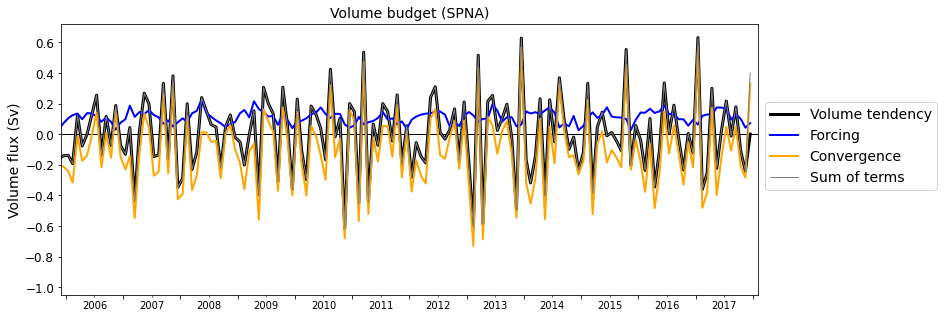

In [33]:
fig, ax = plt.subplots(figsize=(15,5))
ax.set_title(r'Volume budget (SPNA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_volume.time, budg_volume.sel(region='spna',term='tendV'), lw=3, color='black',label='Volume tendency')
ax.plot(budg_volume.time, budg_volume.sel(region='spna',term='forcV'), lw=2, color='blue',label='Forcing')
ax.plot(budg_volume.time, budg_volume.sel(region='spna',term='ConvV'), lw=2, color='orange',label='Convergence')
ax.plot(budg_volume.time, budg_volume.sel(region='spna',term='totalV'), lw=1, color='grey',label='Sum of terms')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([date(2005, 12, 1), date(2018, 2, 1)])
#ax.set_ylim([-0.39, 0.28])

ax.set_ylabel('Volume flux (Sv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


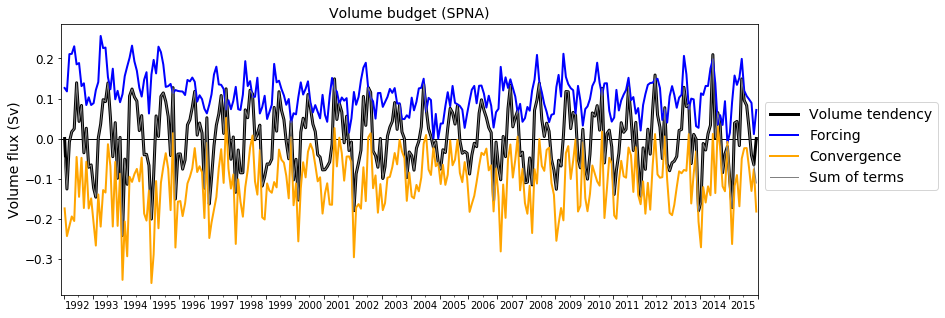

In [28]:
ConvV_spna_bnd = vol_trsp.sel(section='Newfoundland Iberia') + vol_trsp.sel(section='English Channel') \
                    - vol_trsp.sel(section='Hudson Strait') - vol_trsp.sel(section='Davis Strait') \
                    - vol_trsp.sel(section='Denmark Strait') - vol_trsp.sel(section='Iceland Faroe') \
                    - vol_trsp.sel(section='Faroe Scotland')

In [29]:
ConvV_nsea_bnd = vol_trsp.sel(section='Denmark Strait') + vol_trsp.sel(section='Iceland Faroe') \
                    + vol_trsp.sel(section='Faroe Scotland') + vol_trsp.sel(section='Scotland Norway') \
                    - vol_trsp.sel(section='Fram Strait') - vol_trsp.sel(section='Barents Sea')

In [30]:
ConvV_lsea_bnd = vol_trsp.sel(section='Labrador Greenland') - vol_trsp.sel(section='Hudson Strait') \
                    - vol_trsp.sel(section='Davis Strait')

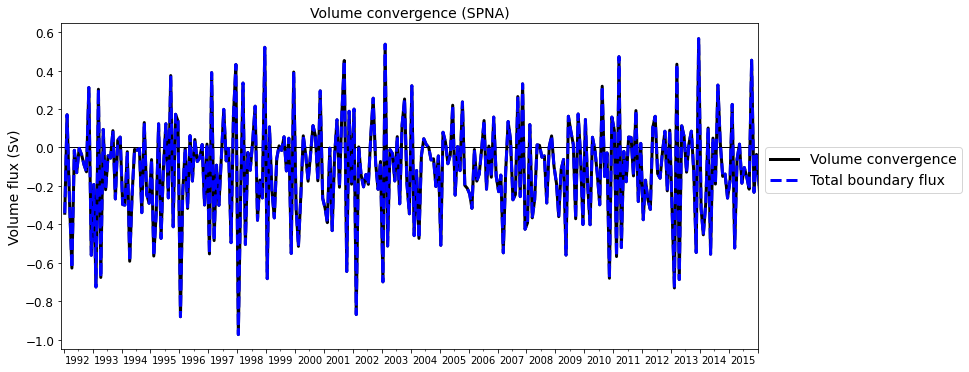

In [31]:
fig, ax = plt.subplots(figsize=(16,6))
ax.set_title(r'Volume convergence (SPNA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_volume.time, budg_volume.sel(region='spna',term='ConvV'), lw=3, color='k',
        label='Volume convergence')
ax.plot(ConvV_spna_bnd.time, ConvV_spna_bnd, lw=3, color='b',ls='--',label='Total boundary flux')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([date(1991, 12, 1), date(2018, 1, 1)])
ax.set_ylabel('Volume flux (Sv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

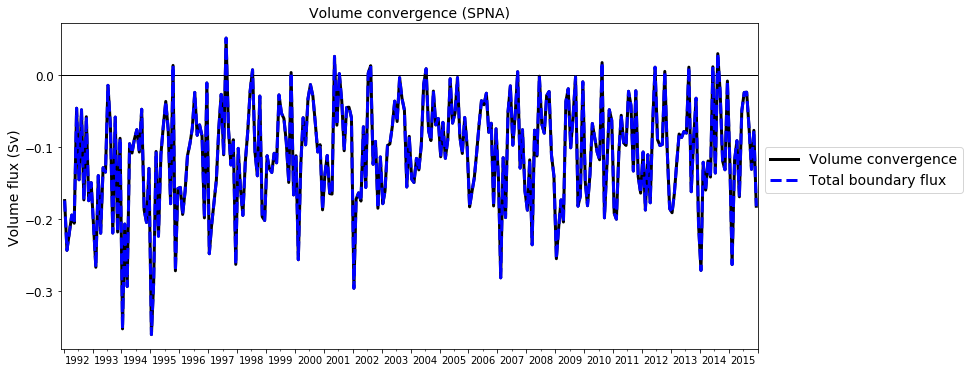

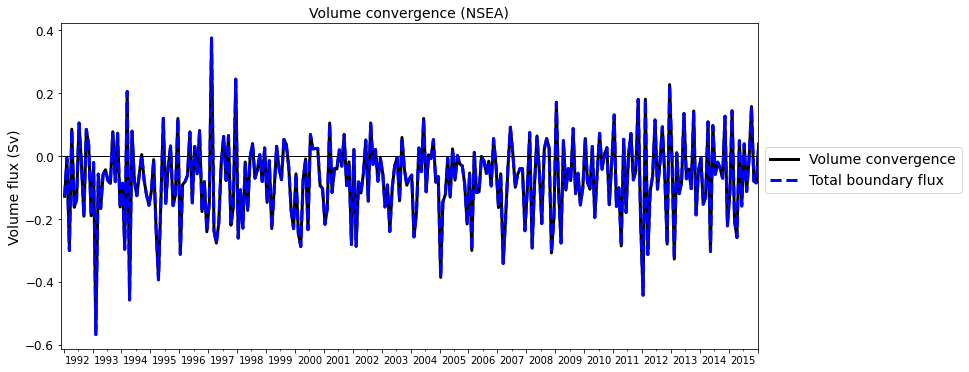

In [32]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title(r'Volume convergence (NSEA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_volume.time, budg_volume.sel(region='nsea',term='ConvV'), lw=3, color='k',
        label='Volume convergence')
ax.plot(ConvV_nsea_bnd.time, ConvV_nsea_bnd, lw=3, color='b',ls='--',label='Total boundary flux')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([date(1991, 12, 1), date(2016, 1, 1)])
ax.set_ylabel('Volume flux (Sv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

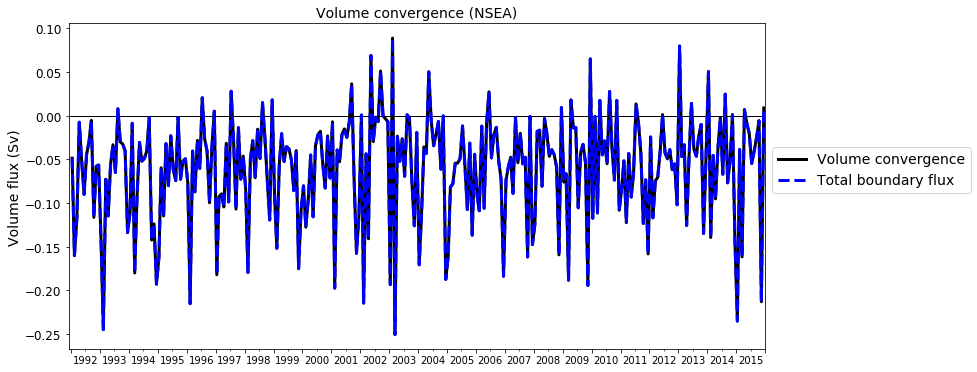

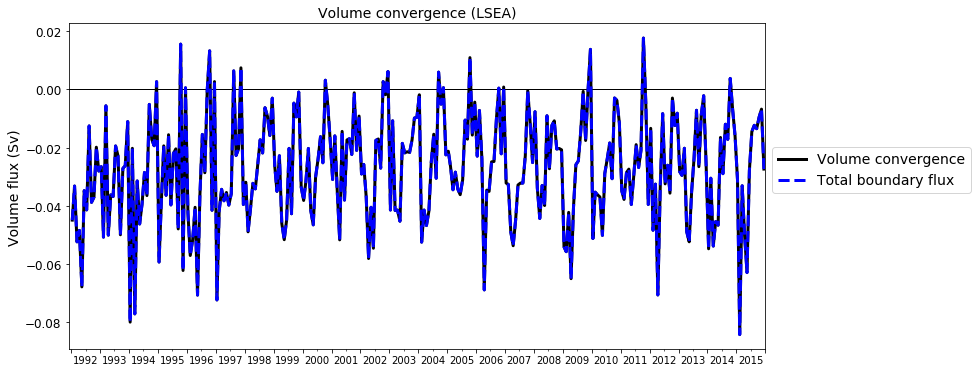

In [29]:
fig, ax = plt.subplots(figsize=(15,6))
ax.set_title(r'Volume convergence (LSEA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_volume.time, budg_volume.sel(region='lsea',term='ConvV'), lw=3, color='k',
        label='Volume convergence')
ax.plot(ConvV_lsea_bnd.time, ConvV_lsea_bnd, lw=3, color='b',ls='--',label='Total boundary flux')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim(['1991-12-01','2016-01-01'])
ax.set_ylabel('Volume flux (Sv)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

### Heat budget

In [34]:
terms = ['tendH', 'forcH', 'adv_ConvH', 'dif_ConvH', 'ConvH', 'totalH', 'ohc']

budg_heat = []

for mask in [main.mask_spna,main.mask_nsea,main.mask_lsea]:
    
    # Temperature tendency (C m^3/s)
    tendH = (budg_vol.tendH*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Forcing (C m^3/s)
    forcH = (budg_vol.forcH*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Advection (C m^3/s)
    adv_ConvH = ((budg_vol.adv_hConvH+budg_vol.adv_vConvH)*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Diffusion (C m^3/s)
    dif_ConvH = ((budg_vol.dif_hConvH+budg_vol.dif_vConvH)*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    # Total convergence (C m^3/s)
    ConvH = adv_ConvH + dif_ConvH
    
    # Sum of terms (C m^3/s)
    totalH = ConvH + forcH
    
    # Heat content (J)
    ohc = ((main.THETA*vol)*mask.where(mask==1)).sum(dim=['tile','k','j','i'])
    
    results = dask.compute(tendH.reset_coords(drop=True)*c_p*rhoconst, forcH.reset_coords(drop=True)*c_p*rhoconst, 
                           adv_ConvH.reset_coords(drop=True)*c_p*rhoconst, 
                           dif_ConvH.reset_coords(drop=True)*c_p*rhoconst, 
                           ConvH.reset_coords(drop=True)*c_p*rhoconst, totalH.reset_coords(drop=True)*c_p*rhoconst,
                           ohc.reset_coords(drop=True)*c_p*rhoconst)
    
    budg = xr.concat(results,pd.Index(terms, name='term'))
    budg_heat.append(budg)

/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))
/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))
/usr/local/lib/python3.6/dist-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in multiply
  return func(*(_execute_task(a, cache) for a in args))


In [35]:
region = ['spna', 'nsea', 'lsea']
budg_heat = xr.concat(budg_heat,pd.Index(region, name='region'))

$$\frac{^\circ C\,m^3}{s} \cdot \frac{J}{kg\,^\circ C} \cdot \frac{kg}{m^3} = \frac{J}{s}$$

#### Save to netcdf

In [36]:
ds = budg_heat.reset_coords(drop=True).to_dataset(name='budg_heat')

In [37]:
ds.to_netcdf('/mnt/efs/data/ecco/eccov4r4_budg_heat.nc', format='NETCDF4')

In [38]:
ls /mnt/efs/data/ecco/

budg_anom/                             ecco_section_transports_fw_eulerian.nc
ecco_budg_anom_fw.nc                   ecco_section_transports_heat.nc
ecco_budg_anom_heat.nc                 ecco_section_transports_slt.nc
ecco_budg_anom_sln.nc                  ecco_section_transports_slt_adv.nc
ecco_budg_fw.nc                        eccov4_spna_fw_flx.csv
ecco_budg_fw_Sref300.nc                eccov4_spna_heat_flx.csv
ecco_budg_fw_oceFW.nc                  eccov4r4/
ecco_budg_heat.nc                      eccov4r4_budg_heat.nc
ecco_budg_oceFW.nc                     eccov4r4_budg_vol.nc
ecco_budg_sln.nc                       eccov4r4_interp_salt.nc
ecco_budg_slt.nc                       eccov4r4_lfwc_nsea_monthly.nc
ecco_budg_vol.nc                       eccov4r4_lfwc_nsea_monthly_anom.nc
ecco_dz.nc                             eccov4r4_lfwc_nsea_pentad.nc
ecco_interp_area.nc                    eccov4r4_lfwc_spna_monthly.nc
ecco_lfwc_spna_monthly.nc              eccov4r4_lfwc_spna_monthly_an

### Plots

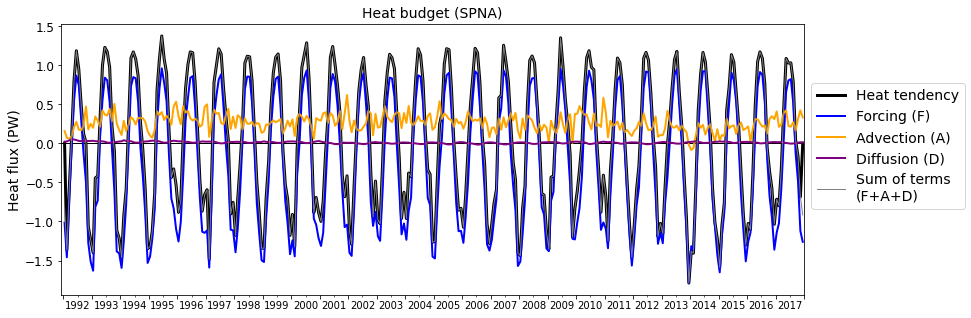

In [39]:
fig, ax = plt.subplots(figsize=(16,5))
ax.set_title(r'Heat budget (SPNA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_heat.time, budg_heat.sel(region='spna',term='tendH')*pw, lw=3, color='black',label='Heat tendency')
ax.plot(budg_heat.time, budg_heat.sel(region='spna',term='forcH')*pw, lw=2, color='blue',label='Forcing (F)')
ax.plot(budg_heat.time, budg_heat.sel(region='spna',term='adv_ConvH')*pw, lw=2, color='orange',label='Advection (A)')
ax.plot(budg_heat.time, budg_heat.sel(region='spna',term='dif_ConvH')*pw, lw=2, color='purple',label='Diffusion (D)')
ax.plot(budg_heat.time, budg_heat.sel(region='spna',term='totalH')*pw, lw=1, color='grey',
        label='Sum of terms\n(F+A+D)')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([date(1991, 12, 1), date(2018, 1, 1)])
ax.set_ylabel('Heat flux (PW)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

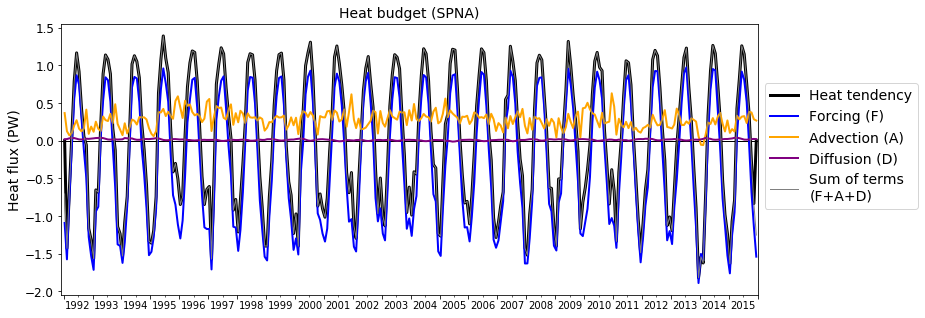

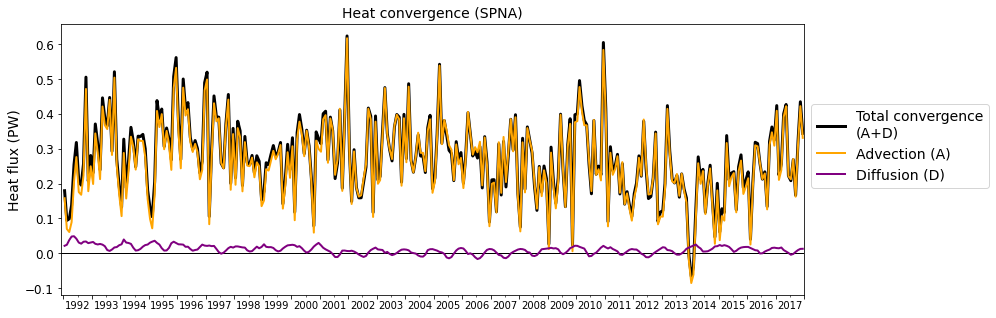

In [40]:
fig, ax = plt.subplots(figsize=(16,5))
ax.set_title(r'Heat convergence (SPNA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_heat.time, budg_heat.sel(region='spna',term='ConvH')*pw, lw=3, color='k',
        label='Total convergence\n(A+D)')

ax.plot(budg_heat.time, budg_heat.sel(region='spna',term='adv_ConvH')*pw, lw=2, color='orange',label='Advection (A)')
ax.plot(budg_heat.time, budg_heat.sel(region='spna',term='dif_ConvH')*pw, lw=2, color='purple',label='Diffusion (D)')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([date(1991, 12, 1), date(2018, 1, 1)])
ax.set_ylabel('Heat flux (PW)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

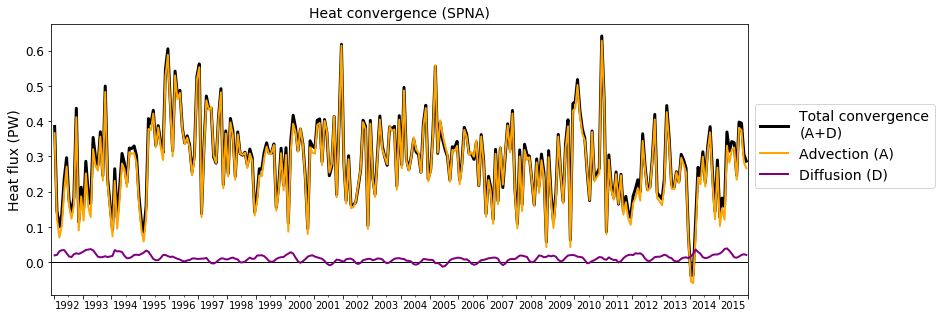

**Default section transports (Boundary fluxes)**

- 'Newfoundland Iberia': into *SPNA*
- 'English Channel': into *SPNA*
- 'Hudson Strait': out of *SPNA* (and out of *LSEA*)
- 'Davis Strait': out of *SPNA* (and out of *LSEA*)
- 'Denmark Strait': out of *SPNA* and into *NSEA*
- 'Iceland Faroe': out of *SPNA* and into *NSEA*
- 'Faroe Scotland': out of *SPNA* and into *NSEA*
- 'Scotland Norway': out of *NSEA*
- 'Fram Strait': out of *NSEA*
- 'Barents Sea': out of *NSEA*
- 'Labrador Greenland': into *LSEA*


In [41]:
ConvH_spna_bnd = heat_trsp.sel(section='Newfoundland Iberia') + heat_trsp.sel(section='English Channel') \
                    - heat_trsp.sel(section='Hudson Strait') - heat_trsp.sel(section='Davis Strait') \
                    - heat_trsp.sel(section='Denmark Strait') - heat_trsp.sel(section='Iceland Faroe') \
                    - heat_trsp.sel(section='Faroe Scotland')

In [42]:
ConvH_nsea_bnd = heat_trsp.sel(section='Denmark Strait') + heat_trsp.sel(section='Iceland Faroe') \
                    + heat_trsp.sel(section='Faroe Scotland') + heat_trsp.sel(section='Scotland Norway') \
                    - heat_trsp.sel(section='Fram Strait') - heat_trsp.sel(section='Barents Sea')

In [43]:
ConvH_lsea_bnd = heat_trsp.sel(section='Labrador Greenland') - heat_trsp.sel(section='Hudson Strait') \
                    - heat_trsp.sel(section='Davis Strait')

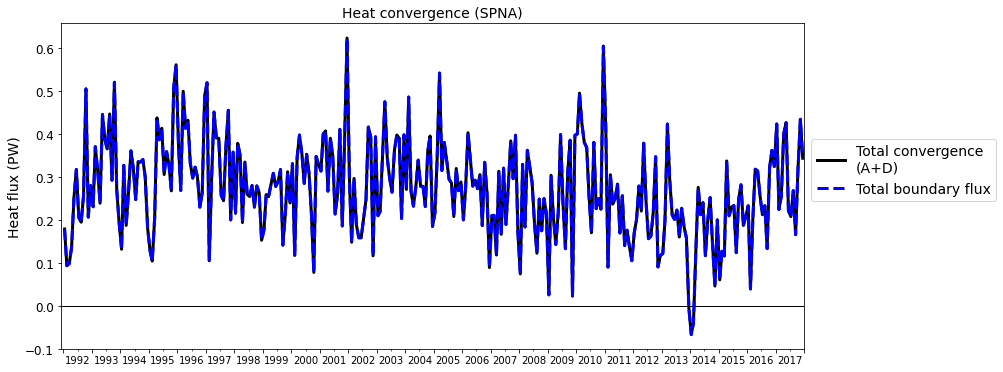

In [44]:
fig, ax = plt.subplots(figsize=(16,6))
ax.set_title(r'Heat convergence (SPNA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_heat.time,budg_heat.sel(region='spna',term='ConvH')*pw, lw=3, color='k',label='Total convergence\n(A+D)')
ax.plot(ConvH_spna_bnd.time, ConvH_spna_bnd, lw=3, color='b',ls='--',label='Total boundary flux')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([date(1991, 12, 1), date(2018, 1, 1)])
ax.set_ylabel('Heat flux (PW)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

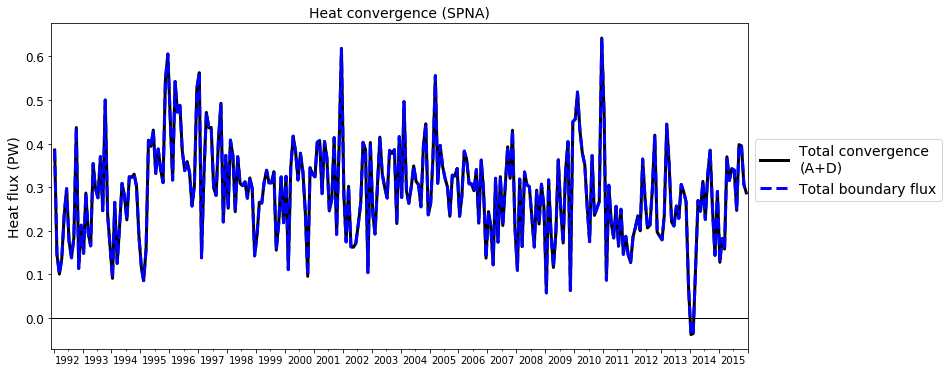

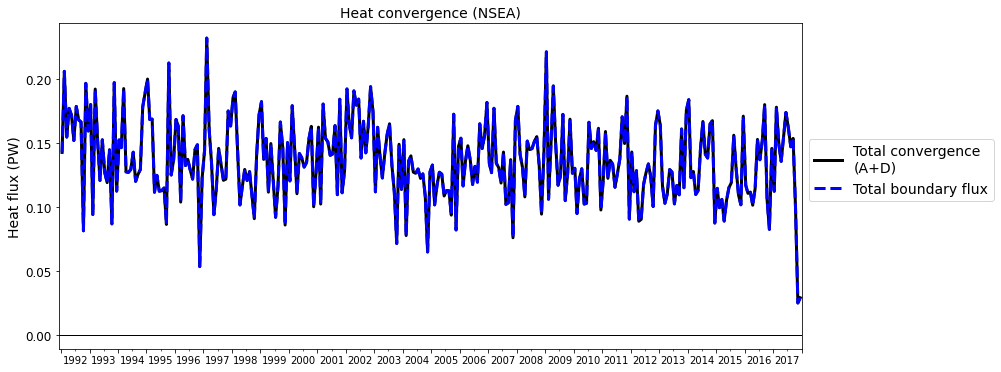

In [45]:
fig, ax = plt.subplots(figsize=(16,6))
ax.set_title(r'Heat convergence (NSEA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_heat.time,budg_heat.sel(region='nsea',term='ConvH')*pw, lw=3, color='k',label='Total convergence\n(A+D)')
ax.plot(ConvH_nsea_bnd.time, ConvH_nsea_bnd, lw=3, color='b',ls='--',label='Total boundary flux')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([date(1991, 12, 1), date(2018, 1, 1)])
ax.set_ylabel('Heat flux (PW)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

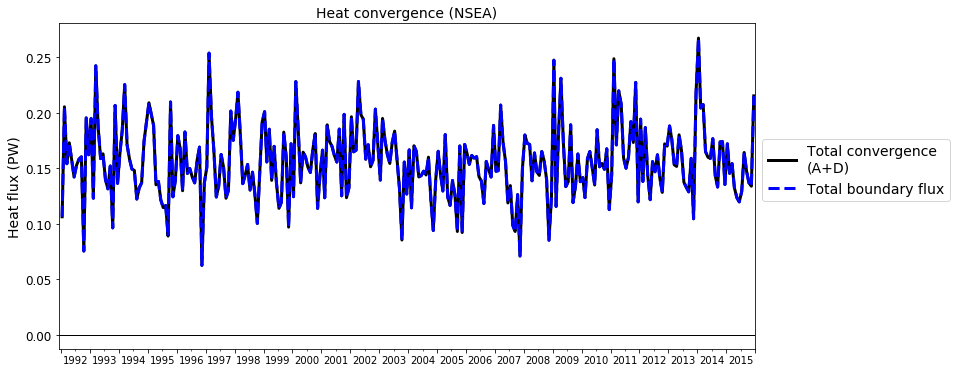

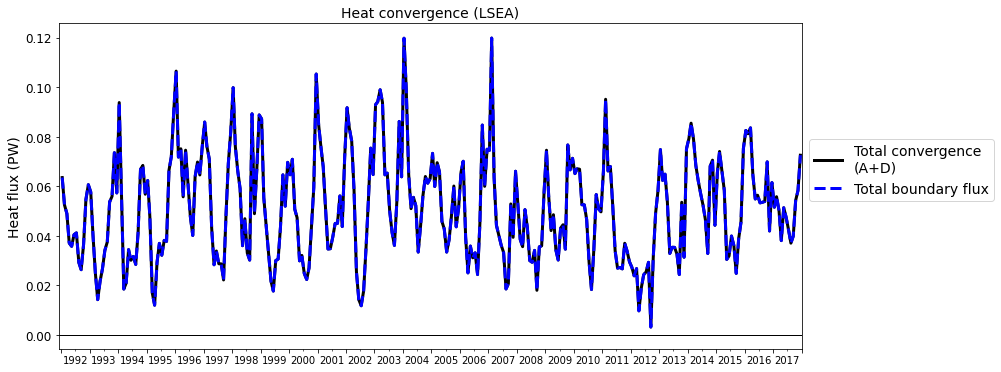

In [46]:
fig, ax = plt.subplots(figsize=(16,6))
ax.set_title(r'Heat convergence (LSEA)',fontsize=14)

ax.axhline(y=0, xmin=0, xmax=1, linewidth=1.0, color = 'k')
ax.plot(budg_heat.time,budg_heat.sel(region='lsea',term='ConvH')*pw, lw=3, color='k',label='Total convergence\n(A+D)')
ax.plot(ConvH_lsea_bnd.time, ConvH_lsea_bnd, lw=3, color='b',ls='--',label='Total boundary flux')

ax.xaxis.set_major_locator(dates.YearLocator())
ax.xaxis.set_minor_locator(dates.YearLocator(month=7))
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_formatter(dates.DateFormatter('%Y'))
for tick in ax.xaxis.get_minor_ticks():
    tick.label.set_fontsize(10)

ax.set_xlim([date(1991, 12, 1), date(2018, 1, 1)])
ax.set_ylabel('Heat flux (PW)',fontsize=14)

#plt.ylim([-0.8e7, 1.0e7])
ax.yaxis.set_tick_params(labelsize=12)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.55),fontsize=14)
fig.subplots_adjust(right=0.77)

#plt.savefig('/tmp/figure.png')
plt.show()

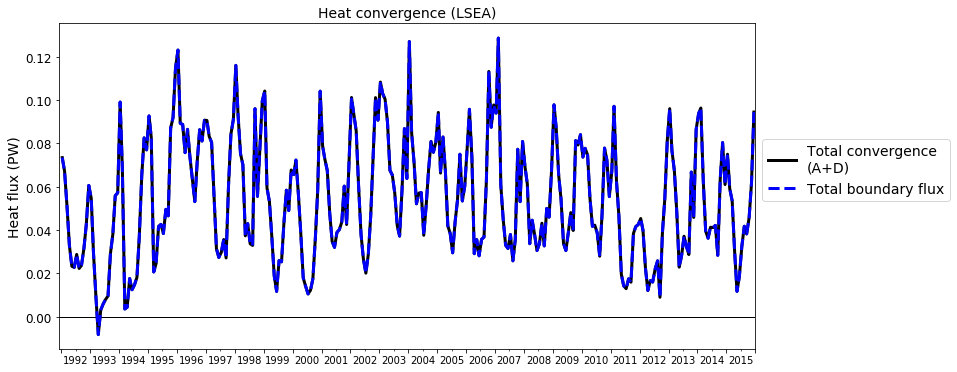